<a href="https://colab.research.google.com/github/nikitakaraevv/reinforcement-learning-algorithms/blob/master/Deep%20Q-Learning/Pong_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install — upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install pyvirtualdisplay
!pip install piglet
!apt-get install python-opengl -y
!apt install xvfb -y

ERROR: Invalid requirement: '—'
     |████████████████████████████████| 71kB 11.6MB/s 
     |████████████████████████████████| 92kB 13.1MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
import numpy as np
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from gym.wrappers import Monitor
from itertools import count

import random
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable

%matplotlib inline
import math
import glob
import io
import os
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [3]:
!git clone https://github.com/higgsfield/RL-Adventure

Cloning into 'RL-Adventure'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55
Unpacking objects: 100% (55/55), done.


In [0]:
import sys
sys.path.append('RL-Adventure')
sys.path.append('RL-Adventure/common')

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env
    

## Random agent

In [0]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [0]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [8]:
env = wrap_env(env)
observation = env.reset()
new_observation = observation
prev_input = None
done = False

for _ in range(1000):
    action = random.randint(1,3)
    new_observation, reward, done, info = env.step(action)
    if done: break  
env.close()
show_video()

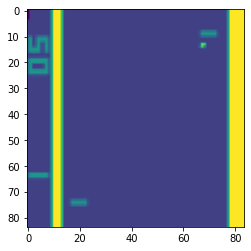

In [9]:
plt.imshow(new_observation[0])

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_path = "/content/drive/My Drive/PongDQN"

## DQN model

In [0]:
from IPython.display import clear_output
from collections import namedtuple

In [0]:
from collections import deque
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [0]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.conv1 = nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        self.lin1 = nn.Linear(self.feature_size(), 512)
        self.lin2 = nn.Linear(512, self.num_actions)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.lin1(x.view(x.size(0), -1)))
        return self.lin2(x)
    
    def feature_size(self):
        return self.conv3(self.conv2(self.conv1(Variable(torch.zeros(1, *self.input_shape))))).view(1, -1).size(1)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
              state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0)).to(device)
              q_value = self.forward(state)
              action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action


In [0]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = Variable(torch.FloatTensor(np.float32(next_state))).to(device)
    action     = Variable(torch.LongTensor(action)).to(device)
    reward     = Variable(torch.FloatTensor(reward)).to(device)
    done       = Variable(torch.FloatTensor(done)).to(device)

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + GAMMA * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data).to(device)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [0]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Define the parameters

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
device

device(type='cuda')

In [0]:
TRAINING_START = 10000
EPS_START = 1.0
EPS_FINAL = 0.01
EPS_DECAY = 30000
MEMORY_SIZE = 100000
LR = 0.00001
NUM_FRAMES = 1400000
BATCH_SIZE = 32
GAMMA      = 0.99

In [0]:
model = DQN(env.observation_space.shape, env.action_space.n)
model = model.to(device)
    
optimizer = optim.Adam(model.parameters(), lr=LR)

replay_buffer = ReplayBuffer(MEMORY_SIZE)

In [0]:
epsilon_by_frame = lambda frame_idx: EPS_FINAL + (EPS_START - EPS_FINAL) * math.exp(-1. * frame_idx / EPS_DECAY)

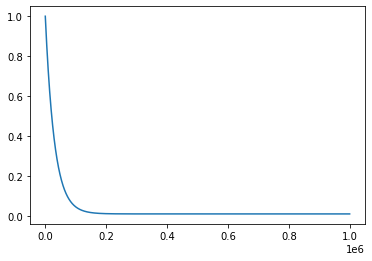

In [55]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## Train the model

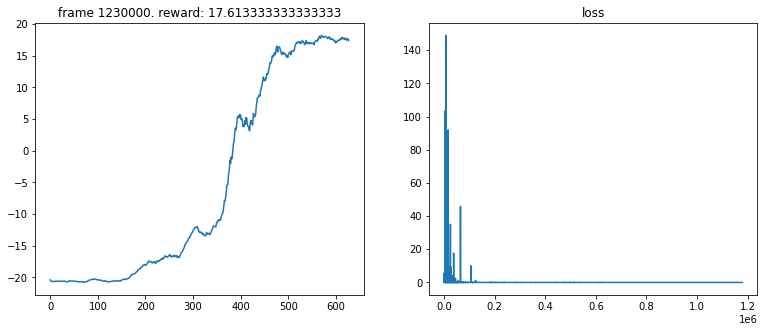

KeyboardInterrupt: ignored

In [57]:
losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, NUM_FRAMES + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(BATCH_SIZE)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, running_mean(all_rewards,30), running_mean(losses,30))

## Save / restore models

In [81]:
state = {
          'model': model.state_dict(),
          'optimizer': optimizer.state_dict(),
          'history': all_rewards,
        }
save_path = os.path.join(data_path, 'log.pkl')
torch.save(state, save_path)
print(f"Saved model parametets to {save_path}")

Saved model parametets to /content/drive/My Drive/PongDQN/log.pkl


In [101]:
restore_path = os.path.join(data_path, 'trained_net.pkl')
if os.path.isfile(restore_path):
    print(f"Load Policy Network parametets from {restore_path}")
    state = torch.load(restore_path)
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    all_rewards1 = state['history']
else:
    print('There is no checkpoint to restore!')

Load Policy Network parametets from /content/drive/My Drive/PongDQN/trained_net.pkl


## Plot the results

In [0]:
import matplotlib as mpl
mpl.style.use('seaborn')

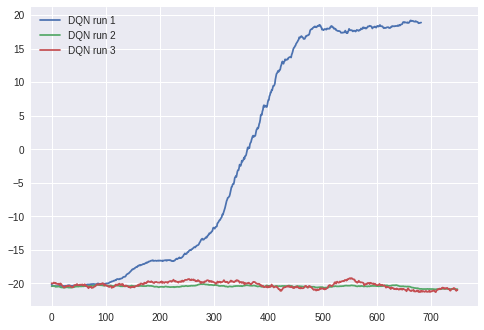

In [124]:
plt.plot(running_mean(his_dqn1,50), label='DQN run 1')
plt.plot(running_mean(his_dqn2,50), label='DQN run 2')
plt.plot(running_mean(his_dqn3,50), label='DQN run 3')
plt.legend()

In [0]:
def show(env, epsilon=0.01, steps=10000):
  running_reward=-21
  show_env = wrap_env(env)
  state = show_env.reset()
  obs=[]
  for t in range(20000):
      obs.append(state)
      action = model.act(state, epsilon)
  
      state, reward, done, _ = env.step(action)
      running_reward+=reward
      if done: break
  print(running_reward)

  show_env.close()
  show_video()
  return obs


In [72]:
obs=show(env=env)

-35.0
